In [ ]:
!pip install lifelines

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=0d6c221e8c131c25e15569c3af9058f6c825bc92f3dfb1bb39023d8ebfcf76b8
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import inspect
import os
import copy
from time import time
from sklearn.svm import SVC
from sklearn import set_config
import seaborn as sn
from sklearn.impute import SimpleImputer
from google.cloud import bigquery
from sklearn import preprocessing, decomposition
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
import lightgbm as lgb
from matplotlib import cm
import matplotlib.pyplot as plt
import datetime
import random
random.seed(1)

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
client = bigquery.Client(project='helical-parity-312503')
sql = """
WITH admission_time AS
(
  SELECT
      p.subject_id, p.dob, p.gender
      , MIN (cha.CHARTTIME) AS first_admittime
  FROM `physionet-data.mimiciii_clinical.patients` p
  LEFT JOIN `physionet-data.mimiciii_clinical.chartevents` as cha
  ON p.subject_id = cha.subject_id
  LEFT JOIN `physionet-data.mimiciii_clinical.d_items` as ite
        ON cha.ITEMID = ite.ITEMID
  LEFT JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` as dia
        ON cha.SUBJECT_ID = dia.SUBJECT_ID
    WHERE (ICD9_CODE LIKE '410%' 
            OR ICD9_CODE LIKE '411%' 
            OR ICD9_CODE LIKE '413%'
            OR ICD9_CODE LIKE '414%'
            OR ICD9_CODE = '412')
    AND ite.ITEMID IN (220603,22062,225693,220050,220051,227688,227007,22744,227429,227444,220277,220283, 220046,220047,
                        227468,220621,226537,5166,225671,227445,227463,220615,220045,220228,3684,3685,6509,6510,220048,
                        220052, 220056, 220058)
  GROUP BY p.subject_id, p.dob, p.gender
)
, ischemic_patients AS (
    SELECT DISTINCT dia.SUBJECT_ID, dia.HADM_ID
    FROM `physionet-data.mimiciii_clinical.diagnoses_icd` as dia
    LEFT JOIN `physionet-data.mimiciii_clinical.chartevents` as cha
        ON cha.SUBJECT_ID = dia.SUBJECT_ID
    LEFT JOIN `physionet-data.mimiciii_clinical.d_items` as ite
        ON cha.ITEMID = ite.ITEMID
    WHERE (ICD9_CODE LIKE '410%' 
            OR ICD9_CODE LIKE '411%' 
            OR ICD9_CODE LIKE '413%'
            OR ICD9_CODE LIKE '414%'
            OR ICD9_CODE LIKE '412%')
    AND ite.ITEMID IN (220603,22062,225693,220050,220051,227688,227007,22744,227429,227444,220277,220283, 220046,220047,
                        227468,220621,226537,5166,225671,227445,227463,220615,220045,220228,3684,3685,6509,6510,220048,
                        220052, 220056, 220058) 
)
, serv AS (
    SELECT
        icu.hadm_id,
        icu.icustay_id,
        se.curr_service,
        IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
        RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
    FROM `physionet-data.mimiciii_clinical.icustays` AS icu
    LEFT JOIN `physionet-data.mimiciii_clinical.services` AS se
    ON icu.hadm_id = se.hadm_id
    AND se.transfertime < DATETIME_ADD(icu.intime, INTERVAL 12 HOUR)
)

SELECT * except (stay_num, death_in_hospital, death_in_icu), 
    CASE WHEN (death_in_hospital + death_in_icu) < 1 THEN 0 ELSE 1 END AS death_flag
FROM
(
    SELECT 
        isp.subject_id, 
        ie.hadm_id AS admission_id, 
        DATE(admt.first_admittime) as first_admittime,
        -- ie.icustay_id,
        ROW_NUMBER() over (partition by ie.subject_id order by adm.admittime DESC, ie.intime DESC) as stay_num,
        --ie.intime AS begin_time_icu, 
        DATE(ie.outtime) AS end_time_icu,
        DATETIME_DIFF(ie.intime, admt.dob, YEAR) as patient_age_admission, 
        -- patient death in hospital is stored in the admissions table
        DATE(adm.deathtime) as deathtime,
        admt.gender,
        se.curr_service,
        se.surgical,
        -- adm.dischtime AS discharge_time,
        adm.MARITAL_STATUS as marital_status, 
        DATETIME_DIFF(ie.outtime, admt.first_admittime, DAY) as num_days_icu,
        CASE
          WHEN deathtime IS NULL
                THEN DATETIME_DIFF(ie.outtime, admt.first_admittime, DAY)
          ELSE DATETIME_DIFF(deathtime, admt.first_admittime, DAY)
        END AS event_time,
        CASE
            WHEN DATETIME_DIFF(adm.admittime, pat.dob, YEAR) <= 1
                THEN 'neonate'
            WHEN DATETIME_DIFF(adm.admittime, pat.dob, YEAR) <= 14
                THEN 'middle'
            WHEN DATETIME_DIFF(adm.admittime, pat.dob, YEAR) > 89
                THEN '>89'
            ELSE 'adult'
        END AS age_group,
        -- the "hospital_expire_flag" field in the admissions table indicates if a patient died in-hospital
        CASE
            WHEN adm.hospital_expire_flag = 1 then 1
        ELSE 0
        END AS death_in_hospital,
        -- note also that hospital_expire_flag is equivalent to "Is adm.deathtime not null?"
        CASE
            WHEN adm.deathtime BETWEEN ie.intime and ie.outtime
                THEN 1
            -- sometimes there are typographical errors in the death date, so check before intime
            WHEN adm.deathtime <= ie.intime
                THEN 1
            WHEN adm.dischtime <= ie.outtime
                AND adm.discharge_location = 'DEAD/EXPIRED'
                THEN 1
            ELSE 0
            END AS death_in_icu,
        DATE(pat.dob) as date_of_birth
    FROM `physionet-data.mimiciii_clinical.icustays` ie
    INNER JOIN ischemic_patients AS isp 
        ON ie.SUBJECT_ID = isp.SUBJECT_ID
    INNER JOIN `physionet-data.mimiciii_clinical.patients` pat
    ON ie.subject_id = pat.subject_id
    INNER JOIN `physionet-data.mimiciii_clinical.admissions` adm
    ON ie.hadm_id = adm.hadm_id
    INNER JOIN admission_time AS admt
    ON ie.SUBJECT_ID = admt.SUBJECT_ID
    INNER JOIN serv AS se
        ON ie.HADM_ID = se.hadm_id
        AND ie.ICUSTAY_ID = se.icustay_id
    WHERE DATETIME_DIFF(adm.admittime, pat.dob, YEAR) >= 15 AND DATETIME_DIFF(adm.admittime, pat.dob, YEAR) < 90
    ORDER BY ie.SUBJECT_ID
)
WHERE stay_num = 1
"""

df = client.query(sql).to_dataframe()
df.head()

,subject_id,admission_id,first_admittime,end_time_icu,patient_age_admission,deathtime,gender,curr_service,surgical,marital_status,num_days_icu,age_group,date_of_birth,death_flag
0,23,124321,2157-10-21,2157-10-22,75,None,M,NSURG,1,MARRIED,1,adult,2082-07-17,0
1,36,165660,2134-05-12,2134-05-16,73,None,M,PSURG,1,MARRIED,4,adult,2061-08-17,0
2,85,112077,2167-07-25,2167-07-27,77,None,M,MED,0,MARRIED,2,adult,2090-09-18,0
3,107,174162,2121-11-30,2122-05-16,70,None,M,MED,0,SEPARATED,167,adult,2052-04-02,0
4,111,155897,2144-07-01,2144-07-01,69,2144-07-01,F,MED,0,MARRIED,0,adult,2075-07-16,1


In [ ]:
df.shape

(6244, 14)

In [ ]:
# df.to_csv("/content/drive/My Drive/patients_data_final.csv")

In [ ]:
df['Status'] = df['death_flag'].apply(lambda x: 'Alive' if x == 0 else 'Dead')

In [ ]:
from matplotlib.ticker import StrMethodFormatter

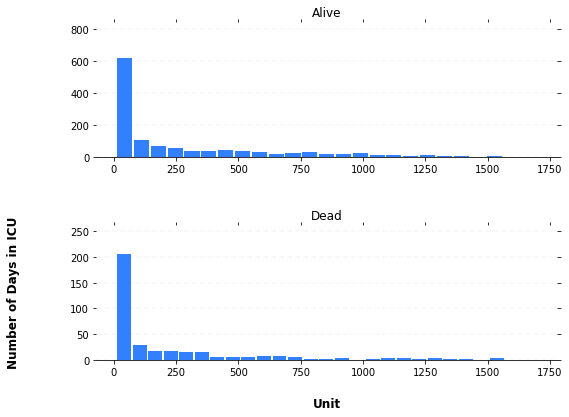

In [ ]:
ax = df[df['num_days_icu'] >= 10].hist(column='num_days_icu', by='Status', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#3380FF', zorder=2, rwidth=0.9)

for i,x in enumerate(ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("Unit", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("Number of Days in ICU", labelpad=50, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=0)


In [ ]:
final_df = df[df['num_days_icu'] >= 10]
# dimensions
m, k = final_df.shape

print("{} x {} table of data:".format(m, k))
display(final_df.head())
print("...")

1658 x 15 table of data:


,subject_id,admission_id,first_admittime,end_time_icu,patient_age_admission,deathtime,gender,curr_service,surgical,marital_status,num_days_icu,age_group,date_of_birth,death_flag,Status
3,107,174162,2121-11-30,2122-05-16,70,None,M,MED,0,SEPARATED,167,adult,2052-04-02,0,Alive
5,124,138376,2165-05-30,2166-02-01,76,2166-02-01,M,MED,0,MARRIED,247,adult,2090-11-19,1,Dead
11,222,103002,2142-06-11,2143-02-18,70,None,F,OMED,0,MARRIED,252,adult,2073-07-25,0,Alive
13,249,158975,2155-02-03,2156-05-11,81,None,F,MED,0,DIVORCED,463,adult,2075-03-13,0,Alive
14,256,108811,2170-06-15,2170-08-19,84,None,M,MED,0,MARRIED,65,adult,2086-07-31,0,Alive


...


In [ ]:
df['Status'].value_counts()

Alive    5459
Dead      785
Name: Status, dtype: int64

## **Fit Kaplan-Meier to dataset** 

In [ ]:
id_list = list(df['subject_id'].unique())

t_list = random.sample(id_list, k=int(0.7*len(id_list)))
test_vali_list = list(set(id_list) - set(t_list))
vali_list = random.sample(test_vali_list, k=int(0.66*len(test_vali_list)))
test_list = list(set(test_vali_list) - set(vali_list))
training_list = t_list + vali_list

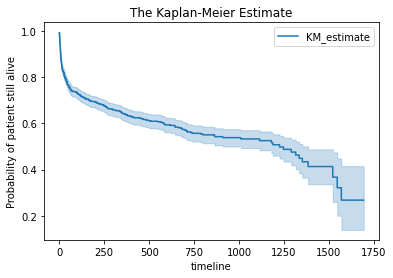

In [ ]:
from lifelines import KaplanMeierFitter

training_df = df[df['subject_id'].isin(training_list)]
T = training_df['num_days_icu']
E = training_df['death_flag']
kmf = KaplanMeierFitter()
kmf.fit(durations=  T, event_observed = E)

# plot the survival function
kmf.plot()
plt.title('The Kaplan-Meier Estimate')
plt.ylabel('Probability of patient still alive')
plt.show()

/usr/local/lib/python3.7/dist-packages/lifelines/plotting.py:710: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


Text(0.5, 0, 'time')

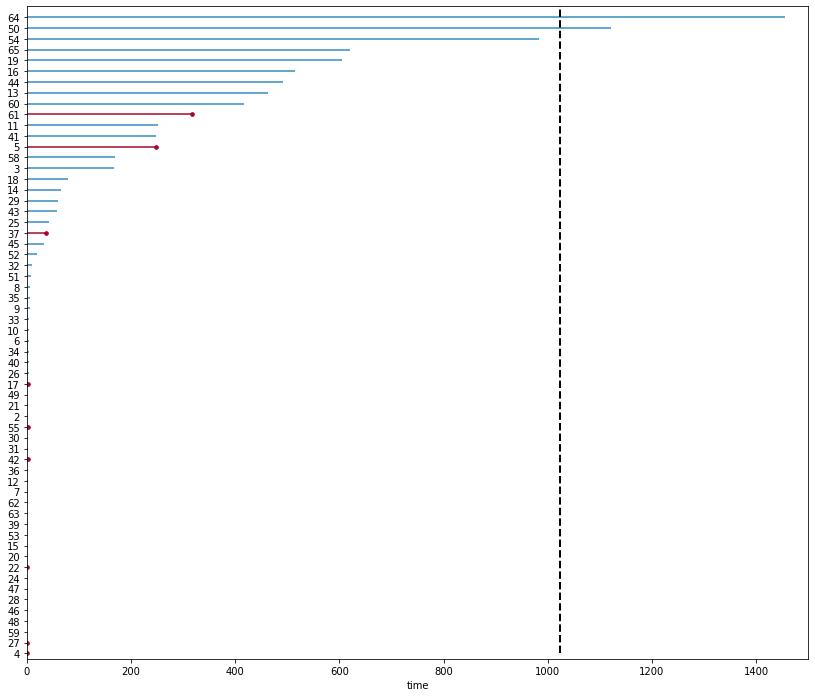

In [ ]:
from lifelines.plotting import plot_lifetimes

tt = training_df['num_days_icu'][:60]
ee = training_df['death_flag'][:60]

fig = plt.figure(figsize=(14,12))
ax = plot_lifetimes(tt, ee)
ax.set_xlim(0, 1500)
ax.vlines(1024, 0, 70, lw=2, linestyles='--')
ax.set_xlabel('time')

In [ ]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,1658,1658
10.0,64,10,54,0,1658
11.0,47,13,34,0,1594
12.0,45,13,32,0,1547
13.0,58,9,49,0,1502
...,...,...,...,...,...
1604.0,1,0,1,0,5
1636.0,1,0,1,0,4
1651.0,1,0,1,0,3


In [ ]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
10.0,0.993969
11.0,0.985862
12.0,0.977578
13.0,0.971720
...,...
1604.0,0.297002
1636.0,0.297002
1651.0,0.297002


### **Kaplan-Meier By Gender**

In [ ]:
kmf_m = KaplanMeierFitter()
kmf_f = KaplanMeierFitter()

In [ ]:
Male = final_df[final_df['gender'] == "M"]
Female = final_df[final_df['gender'] == "F"]

In [ ]:
kmf_m.fit(durations= Male['num_days_icu'], event_observed=Male['death_flag'], label="Male")
kmf_f.fit(durations= Female['num_days_icu'], event_observed=Female['death_flag'], label="Female")

<lifelines.KaplanMeierFitter:"Female", fitted with 637 total observations, 499 right-censored observations>

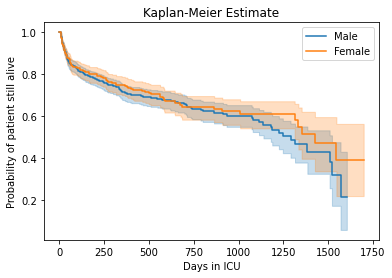

In [ ]:
kmf_m.plot()
kmf_f.plot()

plt.xlabel('Days in ICU')
plt.ylabel('Probability of patient still alive')
plt.title('Kaplan-Meier Estimate')
plt.show()

***PATIENTS VISIT SEQUENCES***

In [ ]:
client = bigquery.Client(project='helical-parity-312503')
sql = """
WITH ischemic_patients AS (
    SELECT DISTINCT dia.SUBJECT_ID, ite.LABEL as features, ite.ITEMID, cha.VALUENUM, DATE(cha.CHARTTIME) as record_date, DATE(pat.DOB) as date_of_birth
    FROM `physionet-data.mimiciii_clinical.diagnoses_icd` as dia
    LEFT JOIN `physionet-data.mimiciii_clinical.chartevents` as cha
        ON cha.SUBJECT_ID = dia.SUBJECT_ID
    LEFT JOIN `physionet-data.mimiciii_clinical.patients` as pat
        ON pat.SUBJECT_ID = dia.SUBJECT_ID
    LEFT JOIN `physionet-data.mimiciii_clinical.d_items` as ite
        ON cha.ITEMID = ite.ITEMID
    WHERE (ICD9_CODE LIKE '410%' 
            OR ICD9_CODE LIKE '411%' 
            OR ICD9_CODE LIKE '413%'
            OR ICD9_CODE LIKE '414%'
            OR ICD9_CODE = '412')
    AND ite.ITEMID IN (220603,22062,225693,220050,220051,227688,227007,22744,227429,227444,220277,220283, 220046,220047,
                        227468,220621,226537,5166,225671,227445,227463,220615,220045,220228,3684,3685,6509,6510,220048,
                        220052, 220056, 220058) 
)
SELECT
    subject_id
    , record_date
    , features AS feature_name
    , ROUND(AVG(value), 3) AS value
FROM
( 
SELECT
    ie.subject_id
    , ip.record_date
    , ip.features 
    , ip.VALUENUM AS value
    -- , CASE 
    --     WHEN ad.deathtime IS NULL THEN 0
    --     WHEN DATE(ad.deathtime) < ip.record_date THEN 0
    --     ELSE 1
    --     END AS Death_Flag
    -- , DATETIME_DIFF(ip.record_date, ip.date_of_birth, YEAR) as patient_age
FROM `physionet-data.mimiciii_clinical.icustays` ie
INNER JOIN ischemic_patients as ip 
    ON ip.SUBJECT_ID = ie.SUBJECT_ID
INNER JOIN `physionet-data.mimiciii_clinical.admissions` ad
    ON ie.SUBJECT_ID = ad.SUBJECT_ID
WHERE ip.valuenum IS NOT NULL 
ORDER BY ie.subject_id, ip.record_date
)
GROUP BY subject_id, record_date, features
ORDER BY subject_id, record_date
"""

chartevent_df = client.query(sql).to_dataframe()
chartevent_df.head(20)

,subject_id,record_date,feature_name,value
0,23,2157-10-21,Arterial Blood Pressure mean,93.636
1,23,2157-10-21,Heart Rate,75.923
2,23,2157-10-21,Hemoglobin,13.100
3,23,2157-10-21,Arterial Blood Pressure diastolic,69.800
4,23,2157-10-21,Heart rate Alarm - High,110.000
5,23,2157-10-21,Arterial Blood Pressure systolic,129.143
6,23,2157-10-21,O2 saturation pulseoxymetry,98.000
7,23,2157-10-21,Creatinine,0.600
8,23,2157-10-21,Glucose (serum),136.000
9,23,2157-10-21,Arterial Blood Pressure Alarm - Low,90.000


In [ ]:
chartevent_df.to_csv("/content/drive/My Drive/patient_chartevents_final.csv")

### **Fit CoxPH to dataset**

**Data preparation**

*Convert the long dataset into a wide one (fill missing values with 0)*

In [ ]:
events_pivoted = chartevent_df.pivot(index=['subject_id', 'record_date'], columns=['feature_name'], values=['value']).sort_values( 'record_date').fillna(0)
events_pivoted.columns = events_pivoted.columns.droplevel()
events_pivoted = events_pivoted.reset_index()

*Take the average of each test for each patient*

In [ ]:
avg_df = events_pivoted.groupby('subject_id', as_index = False).agg('mean')

*Create dummy variables for categorical data*

In [ ]:
train_df = df[df['subject_id'].isin(train_list+vali_list)][['subject_id', 'first_admittime', 'patient_age_admission', 'gender', 'event_time', 'death_flag']]
train_df_cvt = pd.get_dummies(train_df, columns = ['gender'], drop_first = True)

test_df = df[df['subject_id'].isin(test_list)][['subject_id', 'first_admittime', 'patient_age_admission', 'gender', 'event_time', 'death_flag']]
test_df_cvt = pd.get_dummies(test_df, columns = ['gender'], drop_first = True)

train_df_final = train_df_cvt.merge(avg_df, on = ['subject_id'])
test_df_final = test_df_cvt.merge(avg_df, on = ['subject_id'])

**CoxPH model**

In [ ]:
cph = CoxPHFitter()
cph.fit(train_df_final.iloc[:, 2:], duration_col = 'event_time', event_col = 'death_flag')
cph.print_summary()

**Evaluation on the test set**

In [ ]:
pred_score = cph.predict_expectation(test_df_final.iloc[:, 2:])
concordance_index(test_df_final['event_time'], pred_score, test_df_final['death_flag'])